# **VGG 16 Bottleneck Feature extraction Food Classification 230 categories **

---



https://gist.github.com/Thimira/354b90d59faf8b0d758f74eae3a511e2

http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

**Upload following files:**


*   train.txt
*   test.txt
*   cookies.txt (session from OneDrive)
*   client_secrets.json (Upload trained model to Google Drive)



In [6]:
from google.colab import files
uploaded = files.upload()

with open("cookies.txt", 'wb') as f:
    f.write(uploaded[list(uploaded.keys())[0]])

Saving cookies.txt to cookies.txt


**Download following files and unzip them:**

*   chunk_1.zip
*   chunk_2.zip

If existing model wants to be continued learning:

*   inceptionv3_newest.hdf5

In [ ]:
!mkdir images

In [8]:
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F1%2Ezip > chunk_1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 74 7861M   74 5853M    0     0  14.1M      0  0:09:16  0:06:54  0:02:22 13.7M100 7861M  100 7861M    0     0  14.6M      0  0:08:57  0:08:57 --:--:-- 20.6M


In [9]:
!unzip -q chunk_1.zip -d images

warning [chunk_1.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #103498:  bad zipfile offset (local header sig):  10424
  (attempting to re-compensate)


In [ ]:
!rm chunk_1.zip

In [29]:
!ls

client_secrets.json  cookies.txt  datalab  images  test.txt  train.txt


In [11]:
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F2%2Ezip > chunk_2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 75 8107M   75 6086M    0     0  14.6M      0  0:09:14  0:06:56  0:02:18 17.3M100 8107M  100 8107M    0     0  13.1M      0  0:10:17  0:10:17 --:--:-- 9450k


In [12]:
!unzip -q chunk_2.zip -d images

warning [chunk_2.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #103288:  bad zipfile offset (local header sig):  45211
  (attempting to re-compensate)


In [ ]:
!rm chunk_2.zip

In [ ]:
!rm -r images/__MACOSX/

In [15]:
!find images -print | wc -l 

404127


In [ ]:
!find images -name "*.jpg" -size -1k -delete

In [18]:
from google.colab import files

%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import matplotlib.pyplot as plt

%matplotlib inline

from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

Using TensorFlow backend.


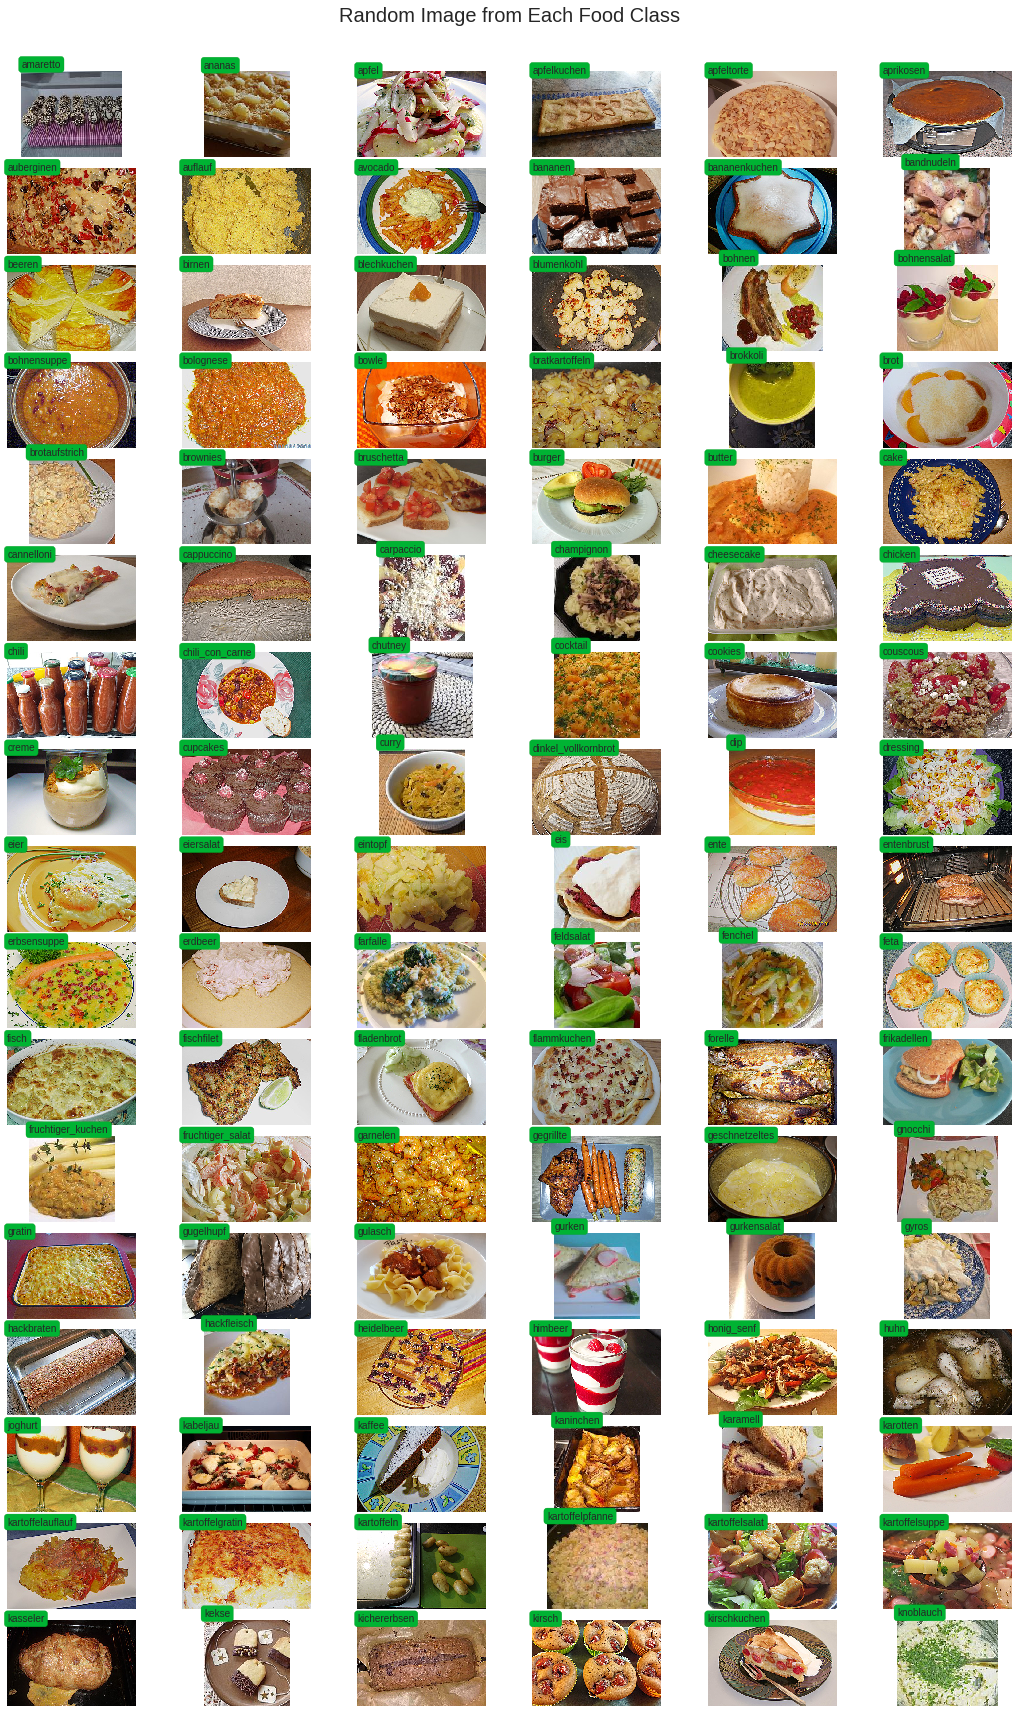

In [19]:
root_dir = 'images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
# Only split files if haven't already
if not os.path.isdir('test') and not os.path.isdir('train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src) # all categories resp. directories
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst[:100]:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('train.txt')
    test_dir_files = generate_dir_file_map('test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('images', 'test', ignore=ignore_train)
    copytree('images', 'train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

In [52]:
!ls

client_secrets.json  datalab  test	train
cookies.txt	     images   test.txt	train.txt


In [53]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7313496330598969422, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
 }
 incarnation: 7252298846877941539
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [54]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   23G  318G   7% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/root       1.2G  537M  684M  44% /opt/bin
tmpfs           6.4G  220M  6.2G   4% /usr/lib64-nvidia
/dev/sda1       365G   40G  325G  11% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
import psutil
psutil.virtual_memory()

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'test'

# number of epochs to train top model
epochs = 5
# batch size used by flow_from_directory and predict_generator
batch_size = 64

In [58]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
print(len(generator.filenames))
print(generator.class_indices)
print(len(generator.class_indices))

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = model.predict_generator(generator, predict_size_train, verbose=1)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = model.predict_generator(generator, predict_size_validation, verbose=1)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

58892288/58889256 [==============================] - 1s 0us/step
Found 10000 images belonging to 100 classes.
10000
{'amaretto': 0, 'ananas': 1, 'apfeltorte': 2, 'bananen': 3, 'bananenkuchen': 4, 'bandnudeln': 5, 'bowle': 6, 'bratkartoffeln': 7, 'brokkoli': 8, 'brownies': 9, 'bruschetta': 10, 'burger': 11, 'butter': 12, 'cannelloni': 13, 'carpaccio': 14, 'chutney': 15, 'cocktail': 16, 'couscous': 17, 'creme': 18, 'dip': 19, 'dressing': 20, 'eis': 21, 'ente': 22, 'entenbrust': 23, 'erdbeer': 24, 'feta': 25, 'flammkuchen': 26, 'frikadellen': 27, 'fruchtiger_salat': 28, 'gegrillte': 29, 'geschnetzeltes': 30, 'gratin': 31, 'gugelhupf': 32, 'gurkensalat': 33, 'gyros': 34, 'hackbraten': 35, 'hackfleisch': 36, 'himbeer': 37, 'huhn': 38, 'kaffee': 39, 'kartoffeln': 40, 'kartoffelpfanne': 41, 'kartoffelsalat': 42, 'kekse': 43, 'kirsch': 44, 'kokos': 45, 'lachsfilet': 46, 'lasagne': 47, 'lauch': 48, 'linsen': 49, 'linsensuppe': 50, 'mandel': 51, 'mango': 52, 'marinade': 53, 'marinierte': 54, 'ma

In [65]:
datagen_top = ImageDataGenerator(rescale=1. / 255)
generator_top = datagen_top.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# save the class indices to use use later in predictions
np.save('class_indices.npy', generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class lebels for the training data, in the original order
train_labels = generator_top.classes

# https://github.com/fchollet/keras/issues/3467
# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

generator_top = datagen_top.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('bottleneck_features_validation.npy')

validation_labels = generator_top.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,epochs=25,batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose=1)

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

Found 10000 images belonging to 100 classes.
Found 9990 images belonging to 100 classes.
Train on 10000 samples, validate on 9990 samples
Epoch 1/25
10000/10000 [==============================] - 5s 484us/step - loss: 4.7588 - acc: 0.0092 - val_loss: 4.5901 - val_acc: 0.0140
Epoch 2/25
10000/10000 [==============================] - 4s 441us/step - loss: 4.5983 - acc: 0.0137 - val_loss: 4.5462 - val_acc: 0.0227
Epoch 3/25
10000/10000 [==============================] - 5s 451us/step - loss: 4.5560 - acc: 0.0156 - val_loss: 4.4847 - val_acc: 0.0265
Epoch 4/25
10000/10000 [==============================] - 5s 453us/step - loss: 4.5108 - acc: 0.0218 - val_loss: 4.4716 - val_acc: 0.0256
Epoch 5/25
 1024/10000 [==>...........................] - ETA: 2s - loss: 4.4598 - acc: 0.022510000/10000 [==============================] - 4s 449us/step - loss: 4.4677 - acc: 0.0242 - val_loss: 4.4523 - val_acc: 0.0281
Epoch 6/25
10000/10000 [==============================] - 4s 448us/step - loss: 4.4296 - 

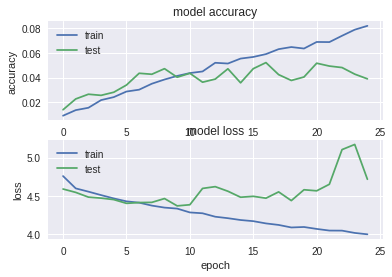

In [66]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
!ls -lha

total 2.0G
drwxr-xr-x   1 root root 4.0K Apr 11 15:39 .
drwxr-xr-x   1 root root 4.0K Apr 11 14:20 ..
-rw-r--r--   1 root root  25M Apr 11 16:31 bottleneck_fc_model.h5
-rw-r--r--   1 root root 958M Apr 11 15:32 bottleneck_features_train.npy
-rw-r--r--   1 root root 957M Apr 11 15:34 bottleneck_features_validation.npy
drwx------   4 root root 4.0K Apr 11 14:31 .cache
-rw-r--r--   1 root root 2.1K Apr 11 16:29 class_indices.npy
-rw-r--r--   1 root root  502 Apr 11 14:31 client_secrets.json
drwxr-xr-x   3 root root 4.0K Apr 11 14:31 .config
-rw-r--r--   1 root root 3.1K Apr 11 14:37 cookies.txt
drwxr-xr-x   1 root root 4.0K Mar 13 21:48 datalab
drwxr-xr-x   4 root root 4.0K Apr 11 14:21 .forever
drwxr-xr-x 232 root root  12K Apr 11 15:00 images
drwxr-xr-x   5 root root 4.0K Apr 11 14:31 .ipython
drwxr-xr-x   3 root root 4.0K Apr 11 15:21 .keras
drwx------   3 root root 4.0K Apr 11 14:21 .local
drwx------   3 root root 4.0K Apr 11 15:20 .nv
-rw-r--r--   1 root root 133K Apr 11 15:21 pred.j

In [92]:
!curl https://static.essen-und-trinken.de/bilder/d5/83/17254/galleryimage/7a442f8304810b64557abeffc47fdfd5.jpg > pred.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32101  100 32101    0     0  32101      0  0:00:01  0:00:01 --:--:-- 25039


[INFO] loading and preprocessing image...

Label: quiche, Probability: 0.273, Image ID: 75


(-0.5, 483.5, 415.5, -0.5)

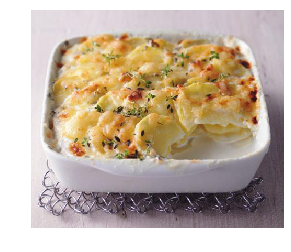

In [93]:
# load the class_indices saved in the earlier step
class_dictionary = np.load('class_indices.npy').item()

num_classes = len(class_dictionary)

# add the path to your test image below
image_path = 'pred.jpg'

print("[INFO] loading and preprocessing image...\n")
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
# important! otherwise the predictions will be '0'
image = image / 255
image = np.expand_dims(image, axis=0)
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
# get the bottleneck prediction from the pre-trained VGG16 model
bottleneck_prediction = model.predict(image)
# build top model
model = Sequential()
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
model.load_weights(top_model_weights_path)
# use the bottleneck prediction on the top model to get the final
# classification
class_predicted = model.predict_classes(bottleneck_prediction)
probabilities = model.predict_proba(bottleneck_prediction)
inID = class_predicted[0]

inv_map = {v: k for k, v in class_dictionary.items()}

label = inv_map[inID]

# get the prediction label
print("Label: {}, Probability: {}, Image ID: {}".format(label, "%.3f" % probabilities[0][inID], inID))

img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')